In [15]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import texcrapy
#from konlpy.corpus import word
from ckonlpy.tag import Twitter, Postprocessor
import json
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer, LTokenizer
from soynlp.noun import LRNounExtractor_v2
import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
import math
import os
import re

from gensim.models import Word2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

from wordcloud import WordCloud

sns.set(style='ticks')
rcParams['font.family'] = u'Malgun Gothic'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\sekan.CA-
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# 아이템별 쿼리데이터(dict) 만들기

In [4]:
df = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','kw_supporter','kw_supported','keywords']]; df
_or = lambda kw: ' OR '.join(['#' + k.strip() for k in kw.split(',')])

qry_base = {row.shortname:_or(row.keywords) for row in df.itertuples()}
supporters = df.shortname[df.kw_supporter==True]
qry_sup = ' OR '.join([qry_base[sup] for sup in supporters]); qry_sup
qry = {row.shortname: '(' + qry_base[row.shortname] + ') AND (' + qry_sup + ')' if row.kw_supported==True else qry_base[row.shortname] for row in df.itertuples()}

In [17]:
%%time
what = ['id', 'timestamp', 'text']
texcrapy.scrap(qry, what=what, lang='ko', end='2019-01-31', download_to='scrapped/twitter')

INFO: queries: ['#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2010-01-01 until:2010-06-15', '#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2010-06-15 until:2010-11-28', '#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2010-11-28 until:2011-05-13', '#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2011-05-13 until:2011-10-26', '#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2011-10-26 until:2012-04-09', '#dailylook OR #outfit OR #bestofstreetwear OR #beststreetoutfit OR #ootd OR #outfitoftheday OR #데일리룩 OR #오오티디 OR #아웃핏 since:2012-04-09 until:2012-09-22', '#dailylook OR #outfit OR #bestofstreetwear OR #bestst


Wall time: 5h 1min 17s


# 사전 만들기

In [143]:
twitter = Twitter()

In [144]:
newwords_kw = [w.strip() for w in ', '.join(df.keywords).split(',')]
newwords_custom = [
    '매거진','1박2일','아우터','항공점퍼','청치마','맨투맨','응답하라','추억팔이','레드벨벳','배꼽티','켄달제너','패션템',
    '스타일리쉬','스타일리시','나들이룩','섹시','섹시미','스타일링','입소문','비현실','세일','레스모아','요거','무개념',
    '보좌진','언제나','간신히','가성비','g1','10k','워킹화','쿠션감','후원금','기업','오니츠카','오니츠카타이거','농구화',
    '황금비율','대다나다','일본기업','슬립온','맥시코','데일리','착화감','마라톤화','젤라이트','너무','예뻐',
    '젤카야노','카야노','신박','이쁜','런닝화','러닝화','체리핑크','체리핑','퓨젝스','골프화','자세히','유투버','신상',
    '신상품','던롭','국대','단체복','스티브잡스','빅토리아시크릿','잡스타그램','a6','테스트모니얼','스트릿패션','스트릿브랜드',
    '굿즈','베리베리','반팔티','지급품','직영점','패셔니스타','패션피플','런스타그램','리미티드에디션','한동안','어글리','젤버즈',
    '아이스버킷챌린지','아이스버킷','챌린지','메탈릭','활력','대폭우','체열반사','보온성','포도몰','아까운','지나친','지티쿨',
    '2hchic','귀욥','클라이마웜','어디서나','어디서든','국가적','투박','젤버즈','키코코스타디노브','코스타디노브',
    'gelburz','월드컵경기장','스파이크리스','매력적','다르빗유','다르빗슈','스와로','반얀트리','그리고','신공항',
    '신발스타그램','선물스타그램','멍스타그램','개스타그램','다리스타그램','왼팔','오른팔','티샤스',
    '언제쯤','푸짐','교환권','서리풀','샌달','클락스','야구화','두류공원','피규어','열심히','브리온',
    '등산화','하그로프스','트레킹화','확실히','멍미','안전화','발성형','아식플','기능성',
    '한국소비자원','흡수성','건조성','오니쓰카',
    '변별력','열정적','혁신적','애슬레저','융합의다리','카이스트교','수침교','라이트쇼','종합운동장','젤소노마',
    '가장교','신스틸러','당일배송','번호이동','꾸리꾸리','한정수량',
    '노티카','키네스','64g','헤어밴드','키보드랙','앙큼','균일가','악세서리','구스다운',
    '친구분','일탈','깔맞춤','축스타그램','코파문디알','젝퍼셀','멕시코66','맥시코66','mexico66',
    '식탐송','리마커블트웬티즈','인센티브','맞이','텅장','지이크파렌하이트','화보집','모닝런',
    '무지개런','노익스큐즈','나스타그램','에프터샥','아미노바이탈','차크라','메달고',
    '진흥공단','스피돔','토리브엔터테인먼트','디자드','엔도서','듸제이불화자씨','베라','생일빵','싸인북',
    '귀여운','플리즈','적당히','물개박수','원아페','노박조코비치','당첨자','일본스니커','도쿄도민',
    '후디티셔츠','레이업로','죄책감런','에너제틱','새로움','그이상','아식스코리아','수촌교'
    '인스파이어','주행거리','마이다스','콀레','오리지날','한표','퓨젝스러쉬','달리자','스프라이핏','게이밍',
    '운동스타그램','만보','참가','열시미','자연추남','미션완료','고마워',
    '젤스팟라이트','운동하는','질러','충전재','디테일','인터벌','gel-ace','무료배송', 
    
]
newwords = list(set(newwords_kw + newwords_custom))
twitter.add_dictionary(newwords, 'Noun')

In [151]:
stopdoc = {'아베골프','포도몰','퐁당','[event]'}

stoptags = {'Foreign','Punctuation','KoreanParticle','Josa','Eomi','PreEomi','Exclamation','Determiner'}
passtags = set(twitter.tagset.keys()) - stoptags
stopwords = {'은','는','이','가','그','후','를','로','주','딱','오','아','다','내','껄','란','시',
             '데','돼','난','이나','거나','좀','들','중','기','년','거','까지','및','된'
             'i','ve','a','got','x','jpg','v','m','s','p','님','님들','구나','와','까','넹','u','is',
             '헐','f','w','의','d','습','니당','있','어요','be','and','pic','댁','욧','너','어','in','o'
            }
ngrams = [
    ('the','boyz'),
    ('어글리','슈즈'),
    ('리미티드','에디션'),
    ('키코','코스타디노브'), ('kiko','kostadinov'),
    ('젤','카야노'),
    ('젤','라이트'),('gel','lyte'),
    ('스튜어트','와이츠먼'),
    ('주니','블랙'),
    ('jun','hyo','seong'),
    ('gel','ptg'),
    ('오니츠카','타이거'),
    ('노박','조코비치'),
    ('후디','티셔츠'),
    ('최종병기','활'),
    ('아이제아','토마스'),
    ('gel','ace')
]

In [152]:
tagger = Postprocessor(twitter, stopwords=stopwords, passtags=passtags, ngrams=ngrams)

### text = 트위터 글 하나하나
### doc = {text: ~, ...}
### docs = [doc1, doc2, ...]

In [ ]:
with open('scrapped/twitter/asics (2010.01.01-2019.01.31).json', encoding='UTF-8-sig') as f:
    jsn = json.load(f)
    
%time toks = texcrapy.tokenize_docs(*jsn['asics'], with_pos=True, tagger=tagger, stopdoc=stopdoc)

# Soynlp 사용

In [5]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = '((?: rt)|(?:^rt))[^ @]?'
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    SPECIALS = r'([^ a-zA-Z0-9_\u3131-\u3163\uac00-\ud7a3]+)|([ㄱ-ㅣ]+)'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    #PTNS = '|'.join((LINEBREAK, RT, URL, HASHTAG, MENTION, EMOJI))
    
    #out = {}
    #text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), '', text.lower())
    text = text.lower()
    
    if remove_url:
        text = re.sub(URL, ' ', text)

    if remove_mention:
        text = re.sub(MENTION, ' ', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, ' ', text)
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    #set_trace()
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS, SPECIALS)), ' ', text)
    return re.sub(LONG_BLANK, ' ', text).strip()



class JsonCorpus:
    def __init__(self, *fnames, textkey='text'):
        self.fnames = fnames
        self.textkey = textkey
        self.corpus = self._corpus()

    def _corpus(self):
        corpus = {}
        for fname in tqdm_notebook(self.fnames):
            with open(fname, encoding='UTF-8-sig') as f:
                js = json.load(f)
                topitem = next(iter(js))
                sents = []
                
                for doc in js[topitem]:
                    sents.append(preproc(doc[self.textkey]))
                    
                corpus[topitem] = sents
                
        return corpus
                
    def __iter__(self):
        for sents in self.corpus.values():
            yield from sents

    def __len__(self):
        return sum([len(sents) for sents in self.corpus.values()])

In [6]:
fnames = ['scrapped/twitter/' + fname for fname in os.listdir('scrapped/twitter')]
jcorpus = JsonCorpus(*fnames)

In [7]:
noun_extractor = LRNounExtractor_v2(verbose=True)
nouns = noun_extractor.train_extract(jcorpus)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 493329 from 429969 sents. mem=0.343 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=6680411, mem=1.455 Gb
[Noun Extractor] batch prediction was completed for 112092 words
[Noun Extractor] checked compounds. discovered 106245 compounds
[Noun Extractor] postprocessing detaching_features : 128251 -> 117025
[Noun Extractor] postprocessing ignore_features : 117025 -> 116918
[Noun Extractor] postprocessing ignore_NJ : 116918 -> 116458
[Noun Extractor] 116458 nouns (106245 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.698 Gb                    
[Noun Extractor] 75.49 % eojeols are covered


In [8]:
newwords_en = WORDS.words()
newwords_kw = [w.strip() for w in ', '.join(df.keywords).split(',')]
newwords_custom = '''
    이벤트, 스포츠, 이투데이, 보좌진, 홍보수석, 체리핑, 체리핑크, 기업, 오니츠카, 오니츠카타이거, 
    마일드세븐, 세븐일레븐, 1949년, 오니츠카기하치로, 운동화, 2013, 시세이도, 
    농구화, 제조회사, 1977년, 깔맞춤, 황금비율, 
    주행거리, 인스파이어, 구입, 오니츠카슬립온, 계속, 생각, 맥시코66, 마라톤화,  hajiwon, 
    연예인, kimchiu, 다시한번, 마린시티, 참가신청, 완료, 제주도, 게이밍, 운동스타그램, 아름다운, 러닝화, 미션완료, 
    크리스마스선물, 아이제아, 질주본능, 어짜피, 소유욕, 뽀대욕, 
    1990년, 보라매공원, 이름값, 이성경, 디자인, 베이스볼, 스파이크, 한그루, 토리브엔터테인먼트, 다방구, 재밌는추억, 
    패션쇼, 스키니진, 프로젝트, 의상학, tryout, 크리스마스, 얼스타그램, 셀스타그램, 콜라보, 
    selfie, 아스크림, 들기름, 에어맥스, 2008, 뭐시기, 이미테이션, 게다가, 
    우먼스, 하의실종, 준비물, 1994년, 패스트, 오프화이트, 인스타, 팬도럼, 
'''

newwords_custom = re.findall(r'[^ ,]+', re.sub(r'\n','',newwords_custom))
newwords = set(newwords_en + newwords_kw + newwords_custom)

In [9]:
stopwords_en = STOPWORDS.words('english')

with open('stopwords-ko.json', encoding='UTF-8-sig') as f:
    stopwords_ko = json.load(f)
    
stopwords_custom = '''
    엔, 줄, 내, 에는, 잖아요, 라는, 데, 는, 것은, 는, 인가요, 란, 말인가, 시, 은, 하네, 이나, 지, 있음, 수, 있는, 
    있으신가, 요, 그렇다면, 하고, 내는, 후, 생, 가거, 한, 하시겠어요, 만, 되네, 하려면, 하다, 랑, 하게, 근데, pic, 님의, 
    호, 하세요, 흑, 적인, 다욧, 니, 보니, 건, 다, 위해, 히, 께, 난, 해, 면서, 용, 보자, 가서, 하는, 중, 도, 
    잉, 인, 울, 하러가기, 인, 준, 든, 이셨으면, 와의, 
    드는, 되네요, 크흐, 이걸, 서, 에도, 됩니다, 하다고, 날, 
    하네요, 했습니다, 해지네요, 이였냐, 더, 
    되니, 하지않을, 아아, htm, 고, 냐고, 이야, 아니야, 너네, 된, 이냐, 해봐라, 해서, 
    vi, 
'''    

stopwords_custom = re.findall(r'[^ ,]+', re.sub(r'\n','',stopwords_custom))
stopwords = set(stopwords_en + stopwords_ko)# + stopwords_custom)

In [10]:
scores = {noun:nounscore.score for noun, nounscore in nouns.items()}

for w in newwords:
    scores[w] = 1

In [11]:
ltokenizer = LTokenizer(scores=scores)
#for corp in jcorpus.corpus['nike']:
#    print([tok for tok in ltokenizer.tokenize(corp, tolerance=0.0) if tok not in stopwords])
    #print(ltokenizer.tokenize(corp, tolerance=0.0))

In [12]:
class Tokens:
    def __init__(self, jcorpus):
        self.tokensdict = self._get_tokens(jcorpus)
    
    def _get_tokens(self, jcorpus):
        tokens = {}
        for item, docs in tqdm_notebook(jcorpus.corpus.items()):
            tokens[item] = [
                [tok for tok in ltokenizer.tokenize(doc, tolerance=0.0) if tok not in stopwords] 
                for doc in docs
            ]
        return tokens
    
    
    def freq(self):
        return {
            item: Text(sum(toks, [])).vocab() 
            for item, toks in tqdm_notebook(self.tokensdict.items())
            if item not in ['ootd','fashion','category']
        }
                
    def __iter__(self):
        for toks in self.tokensdict.values():
            yield from toks
            
    def __len__(self):
        return sum([len(toks) for toks in self.tokensdict.values()])

In [13]:
tokens = Tokens(jcorpus)

In [14]:
tokensfreq = tokens.freq()

In [16]:
with open('model/tokensfreq.json', 'w', encoding='UTF-8-sig') as f:
    json.dump(tokensfreq, f, ensure_ascii=False)

In [15]:
tokensfreq

FreqDist({'나이키': 15763, 'nike': 12253, '한': 2030, 'view': 1570, '해외': 1482, '슈즈': 1472, '제품': 1464, '코르테즈': 1458, '공유': 1406, '직구': 1404, ...})

# Word2vec

In [29]:
w2v = Word2Vec(tokens, size=100, window=5, min_count=10, workers=4, sg=1)
w2v.save('model/word2vec.model')

In [32]:
w2v.init_sims(replace=True)

In [33]:
w2v = Word2Vec.load('model/word2vec.model')

In [34]:
w2v.wv.most_similar(positive=['품격'], topn=10)

[('레이디라이크', 0.7703089714050293),
 ('고혹', 0.7489721775054932),
 ('관능미', 0.7474839687347412),
 ('수놓은', 0.7430015802383423),
 ('팔색조', 0.73946613073349),
 ('보여준', 0.7381678819656372),
 ('모던함', 0.7380876541137695),
 ('없이도', 0.7372814416885376),
 ('세련미', 0.7350413799285889),
 ('더없이', 0.7339192032814026)]

In [ ]:
w2v.wv.similarity('무난','유니클로')

In [35]:
id_pools = {
    '가성비': ['가성비','저렴','효율','성능','실용'], 
    '트렌디': ['유행','트렌드','trend','trendy'],#,'민감'],
    '신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    '럭셔리': ['럭셔리','고급','호화','luxury'], #,'품격'
    '유니크': ['유니크','독특','독창','unique','개성','only','참신','특이'],
    '활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    '과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 정통, 격식, 아이디어, 변화, 변동, 환상, 신상, 새로운, 튀는, 
}

In [ ]:
#docs = sum(tokens_dict.values(), [])

In [55]:
dct = Dictionary(tokens)
dct.filter_extremes(no_below=20, no_above=0.2)
dct.compactify()

In [37]:
corp = {item:[dct.doc2bow(tok) for tok in toks] for item, toks in tqdm_notebook(tokens.tokensdict.items())}

In [39]:
model_tfidf = TfidfModel(sum(corp.values(),[]), id2word=dct)

In [40]:
wordlist = list(dct.values())
identities = list(id_pools.keys())
brands = list(tokens.tokensdict.keys())

In [41]:
sim_mat = np.zeros((len(identities),len(wordlist)))
for i, idty in enumerate(tqdm_notebook(identities)):
    for j, word in enumerate(wordlist):
        sims = []
        for w in id_pools[idty]:
            try:
                sims.append(w2v.wv.similarity(w, word))
            except:
                sims.append(0)
        sim_mat[i,j] = np.mean(sims)
        #sim_mat[i,j] = np.mean([w2v.wv.similarity(w, word) for w in id_pools[idty]])

In [42]:
sim_mat.shape

(7, 24024)

In [43]:
def get_brand_vecs(bname):
    brand_tfidf  = model_tfidf[corp[bname]]
    return np.vstack([sparse2full(c, len(dct)) for c in brand_tfidf]).mean(axis=0)

def plot_id(bname):
    val = sim_mat.dot(get_brand_vecs(bname))
    #val /= val.sum()
    pd.Series(val, index=identities).plot.barh()

In [49]:
id_dict = {}
for bname in brands:
    if bname not in ['ootd','fashion','category']:
        try:
            id_dict[bname] = sim_mat.dot(get_brand_vecs(bname))
        except:
            print(bname)

#id_dict = {
#    bname:sim_mat.dot(get_brand_vecs(bname)) 
#    for bname in tqdm_notebook(brands)
#    if bname not in ['ootd','fashion','category']
#}

advisoryboardcrystals
doublet
engineeredgarment
experthorror
goat
heliotemil
ignoredprayers
novacancyinn
onlineceramics
saterdaysnyc
someware
sssworldcorp
ystrdystmrrw


In [53]:
pd.DataFrame(id_dict, index=identities).to_pickle('model/id_dict.pkl')

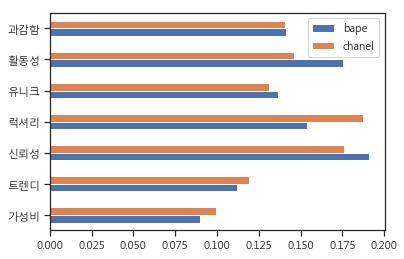

In [88]:
df = pd.read_pickle('model/id_dict.pkl')
df /= df.sum()
df[['bape','chanel']].plot.barh()

# 여기서 normalize 축을 바꾸면 어떨까?

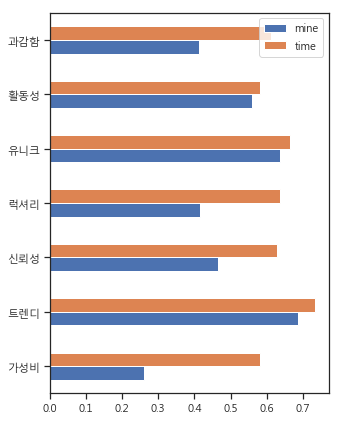

In [7]:
df = pd.read_pickle('model/id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df.T).T
df2 = df.copy()
df2[:] = X_train_minmax
df2[['mine','time']].plot.barh(figsize=(5,7))

In [ ]:
df2.T

In [9]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                     2
1017alyx9sm             17
8seconds                 2
99percentis              2
aape                     1
abecrombiefitch         11
acnestudios             17
acoldwall                0
acronym                  9
adererror               17
adidas                   9
adidasoriginal          13
aecawhite                0
aimeleondore             1
aldo                    12
alexandermcqueen         4
alexanderwang            3
allsaints               14
alphaindustry            0
ambush                  17
ami                      3
amiri                    4
antisocialsocialclub     0
apc                     14
arcteryx                11
asics                   10
awakeny                  1
balenciaga               7
bally                    4
balmain                  4
                        ..
tomsshoes               11
topshop                  2
topten                  11
toryburch                4
tumi                    11
ugg                      6
u

In [12]:
clrd = pd.DataFrame(clustered.sort_values()).reset_index()
clrd.columns = ['bname', 'cluster']
clrd.to_excel('model/clustered.xlsx')

In [20]:
clrd[clrd.bname=='adidas']

,bname,cluster
155,adidas,9


In [21]:
clustered.index[clustered==9]

Index(['acronym', 'adidas', 'beanpole', 'buckaroo', 'champion', 'converse',
       'drmartens', 'dynafit', 'eider', 'eytys', 'giordano', 'gyakusou',
       'henderscheme', 'heritagefloss', 'herschel', 'huf', 'johnelliott',
       'lynn', 'maisonkitsune', 'mandarinaduck', 'mizuno', 'montbell',
       'patagonia', 'puma', 'salomon', 'series', 'thrasher', 'undefeated',
       'uniqlo'],
      dtype='object')

In [8]:
df2.loc['신뢰성']

032c                    0.340455
1017alyx9sm             0.425155
8seconds                0.339285
99percentis             0.357623
aape                    0.286948
abecrombiefitch         0.627947
acnestudios             0.398733
acoldwall               0.548392
acronym                 0.514335
adererror               0.436773
adidas                  0.458249
adidasoriginal          0.840801
aecawhite               0.640928
aimeleondore            0.243071
aldo                    0.339888
alexandermcqueen        0.482478
alexanderwang           0.431424
allsaints               0.473768
alphaindustry           0.567853
ambush                  0.389805
ami                     0.485296
amiri                   0.474698
antisocialsocialclub    0.601762
apc                     0.408848
arcteryx                0.738530
asics                   0.528915
awakeny                 0.317562
balenciaga              0.784627
bally                   0.524232
balmain                 0.467375
          

In [136]:
df_kw = pd.read_excel('keywords and logos.xlsx', sheet_name='20190215')[['shortname','keywords']].set_index('shortname')
df_kw

,keywords
shortname,
ootd,"dailylook, outfit, bestofstreetwear, beststree..."
category,"designer, streetwear, luxury, casual, sportswe..."
fashion,"fashion, brand, fashionbrand, shoe, shoes, clo..."
8seconds,"8seconds, 8second, 에잇세컨즈, 8세컨즈"
adidas,"adidas, 아디다스"
adidasoriginal,"adidasoriginal, 아디다스오리지널스, 아디다스오리지널, 아디다스오리지날스..."
asics,"asics, 아식스"
balenciaga,"balenciaga, balensiaga, 발렌시아가"
bally,"bally, 발리"


In [163]:
def plot_wc(bname):
    with open('model/tokensfreq.json', encoding='UTF-8-sig') as f:
        j = json.load(f)[bname]
        kws = [kw.strip() for kw in df_kw.keywords.loc[bname].split(',')]
        [j.pop(kw, None) for kw in kws]

    x,y = np.ogrid[:300, :300]
    mask = (x-150)**2 + (y-150)**2 > 130**2
    mask = 255 * mask.astype(int)
        
    font_path = r'c:\Windows\Fonts\NanumBarunGothic.ttf'
    wc = WordCloud(width=100, height=100, background_color='white', font_path=font_path, random_state=0, mask=mask)
    
    try:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.imshow(wc.generate_from_frequencies(j), interpolation='bilinear')
        ax.axis('off')
        fig.savefig('model/wordcloud/wc_' + bname + '.png', format='png')
        
    except:
        print(bname)
        
    finally:
        plt.close(fig)

In [164]:
for row in tqdm_notebook(df_kw.itertuples()):
    bname = row.Index
    
    fname = 'model/wordcloud/wc_' + bname + '.png'
    if os.path.isfile(fname):
        continue
        
    if bname not in ['ootd','fashion','category']:
        plot_wc(bname)

doublet
engineeredgarment
ignoredprayers
saterdaysnyc
advisoryboardcrystals
experthorror
goat
heliotemil
novacancyinn
onlineceramics
someware
sssworldcorp
ystrdystmrrw
